In [1]:
from siepic import all as pdk
from ipkiss3 import all as i3
from ipkiss3 import constants
from ipkiss.process.layer_map import GenericGdsiiPPLayerOutputMap
from ring_resonator_cell import RingResonator
from ring_resonator_calib_cell import RingResonator_calib
from datetime import datetime
import numpy as np
import pylab as plt
from scipy.io import savemat, loadmat
import pickle

In [2]:
# We make a copy of the layer dictionary to freely modify it
pplayer_map = dict(i3.TECH.GDSII.LAYERTABLE)
# Write the content to be written on WG_P6NM on Silicon layer directly
pplayer_map[i3.TECH.PROCESS.WG_P6NM, i3.TECH.PURPOSE.DRAWING] = pplayer_map[i3.TECH.PROCESS.WG, i3.TECH.PURPOSE.DRAWING]
output_layer_map = GenericGdsiiPPLayerOutputMap(pplayer_map=pplayer_map)

In [3]:
# Parameter sweep for ring resonator
coupling_lengths = np.arange(0, 4, 0.5)

In [4]:
bend_radius = 5.0
x0 = 5.0
y0 = 5.0
x_spacing = 5.0

In [5]:
insts = dict()
specs = []

# Create the floor plan for EdX design area
floorplan = pdk.FloorPlan(name="FLOORPLAN", size=(605.0, 410.0))

# Add the floor plan to the instances dict and place it at (0.0, 0.0)
insts["floorplan"] = floorplan
specs.append(i3.Place("floorplan", (0.0, 0.0)))
# Initialize the text label dictionary
text_label_dict = {}  # Text labels dictionary for automated measurement labels
circuit_cell_names = []  # Constituent circuit cell names list

In [6]:
# Create the sweep over coupling length for ring resonators
for ind, coupling_length in enumerate(coupling_lengths, start=1):
    rr = pdk.EbeamAddDropSymmStraight(coupler_length=coupling_length)
    # Instantiate the MZI
    rr = RingResonator(
        name="Ring_Resonator_cl{:.2f}".format(coupling_length),
        ring=rr,
        bend_radius=bend_radius,
    )

    # Add the MZI to the instances dict and place it
    rr_cell_name = "RRcl{}".format(ind)
    insts[rr_cell_name] = rr

    # Put the measurement label
    meas_label = f"{rr.measurement_label_pretext}{rr_cell_name}"
    size_info = rr.Layout().size_info()
    x_pos = x0 + abs(size_info.west)
    y_pos = y0 + abs(size_info.south)
    # Space dynamically allocated depending on the size of the PCell
    specs.append(i3.Place(rr_cell_name, (x_pos, y_pos)))
    meas_label_coord = rr.measurement_label_position + (x_pos, y_pos)
    text_label_dict[rr_cell_name] = [meas_label, meas_label_coord]
    circuit_cell_names.append(rr_cell_name)

    # Place the next circuit to the right of GDS layout
    x0 += size_info.width + x_spacing

In [7]:
rr_cal = RingResonator_calib(
    name="Ring_Resonator_calibration",
    bend_radius=bend_radius,
)

# Add the calibration circuit to the instances dict and place it
rr_cell_name = "RRc"
insts[rr_cell_name] = rr_cal


In [8]:
# Put the measurement label
meas_label = f"{rr_cal.measurement_label_pretext}{rr_cell_name}"
size_info = rr_cal.Layout().size_info()
x_pos = x0 + abs(size_info.west)
y_pos = y0 + abs(size_info.south) + rr_cal.fgc_spacing_y
specs.append(i3.Place(rr_cell_name, (x_pos, y_pos)))
meas_label_coord = rr_cal.measurement_label_position + (x_pos, y_pos)
text_label_dict[rr_cell_name] = [meas_label, meas_label_coord]
circuit_cell_names.append(rr_cell_name)

In [9]:
# Create the final design with i3.Circuit
top_cell = i3.Circuit(
    name=f"EBeam_OngunArisev_E_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}",
    insts=insts,
    specs=specs,
)

In [10]:
# Bigger visualization
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100


In [11]:
text_elems = []
# For the GDS text elements for automated measurement
for cell in circuit_cell_names:
    text_label = text_label_dict[cell][0]
    text_label_coord = text_label_dict[cell][1]
    text_elems += i3.Label(layer=i3.TECH.PPLAYER.TEXT, text=text_label,
                          coordinate=text_label_coord,
                          alignment=(constants.TEXT.ALIGN.LEFT, constants.TEXT.ALIGN.BOTTOM), height=2)

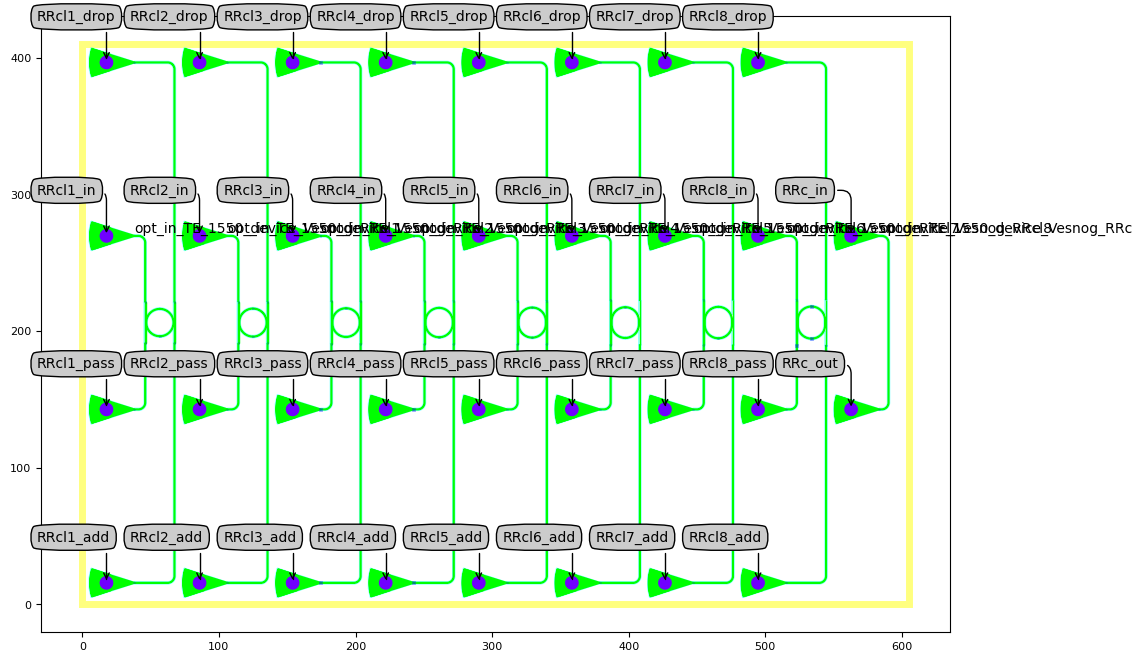

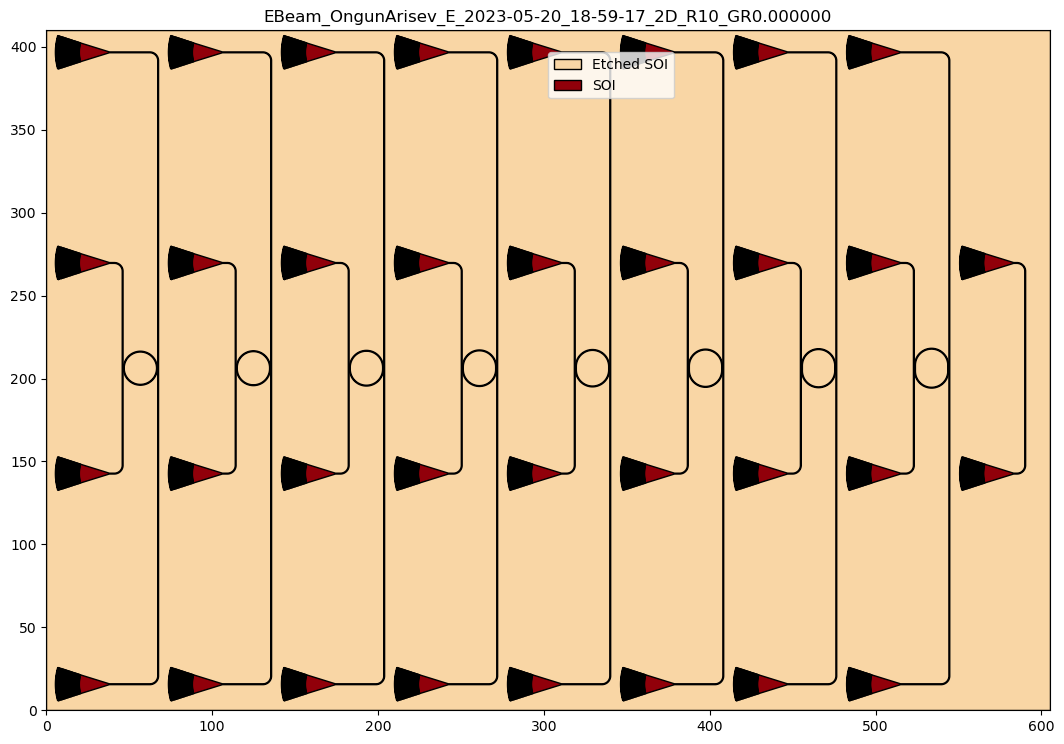

C:\Users\ongun\PycharmProjects\ipkiss_training\EBeam_Vesnog_E.gds

In [12]:
# Layout
filename = "EBeam_Vesnog_E.gds"
cell_lv = top_cell.Layout()
cell_lv.append(text_elems)
cell_lv.visualize(annotate=True)
cell_lv.visualize_2d()
cell_lv.write_gdsii(filename, layer_map=output_layer_map)


In [13]:
# Circuit model
cell_cm = top_cell.CircuitModel()
wavelengths = np.linspace(1.52, 1.58, 4001)
S_total = cell_cm.get_smatrix(wavelengths=wavelengths)


C:\ProgramData\Anaconda3\envs\ipkiss3\lib\site-packages\ipkiss3\simulation\engines\caphe_circuit_sim\caphenodegenerator.py:376: UserWarning: The following child nodes are not connected and will be removed:
floorplan
  warn(msg)


C:\ProgramData\Anaconda3\envs\ipkiss3\lib\site-packages\ipkiss3\numerical.py:78: RuntimeWarning: divide by zero encountered in log10
  return 20.0 * numpy.log10(numpy.abs(y))
C:\ProgramData\Anaconda3\envs\ipkiss3\lib\site-packages\ipkiss3\numerical.py:78: RuntimeWarning: divide by zero encountered in log10
  return 20.0 * numpy.log10(numpy.abs(y))
C:\ProgramData\Anaconda3\envs\ipkiss3\lib\site-packages\ipkiss3\numerical.py:78: RuntimeWarning: divide by zero encountered in log10
  return 20.0 * numpy.log10(numpy.abs(y))
C:\ProgramData\Anaconda3\envs\ipkiss3\lib\site-packages\ipkiss3\numerical.py:78: RuntimeWarning: divide by zero encountered in log10
  return 20.0 * numpy.log10(numpy.abs(y))
C:\ProgramData\Anaconda3\envs\ipkiss3\lib\site-packages\ipkiss3\numerical.py:78: RuntimeWarning: divide by zero encountered in log10
  return 20.0 * numpy.log10(numpy.abs(y))
C:\ProgramData\Anaconda3\envs\ipkiss3\lib\site-packages\ipkiss3\numerical.py:78: RuntimeWarning: divide by zero encountered i

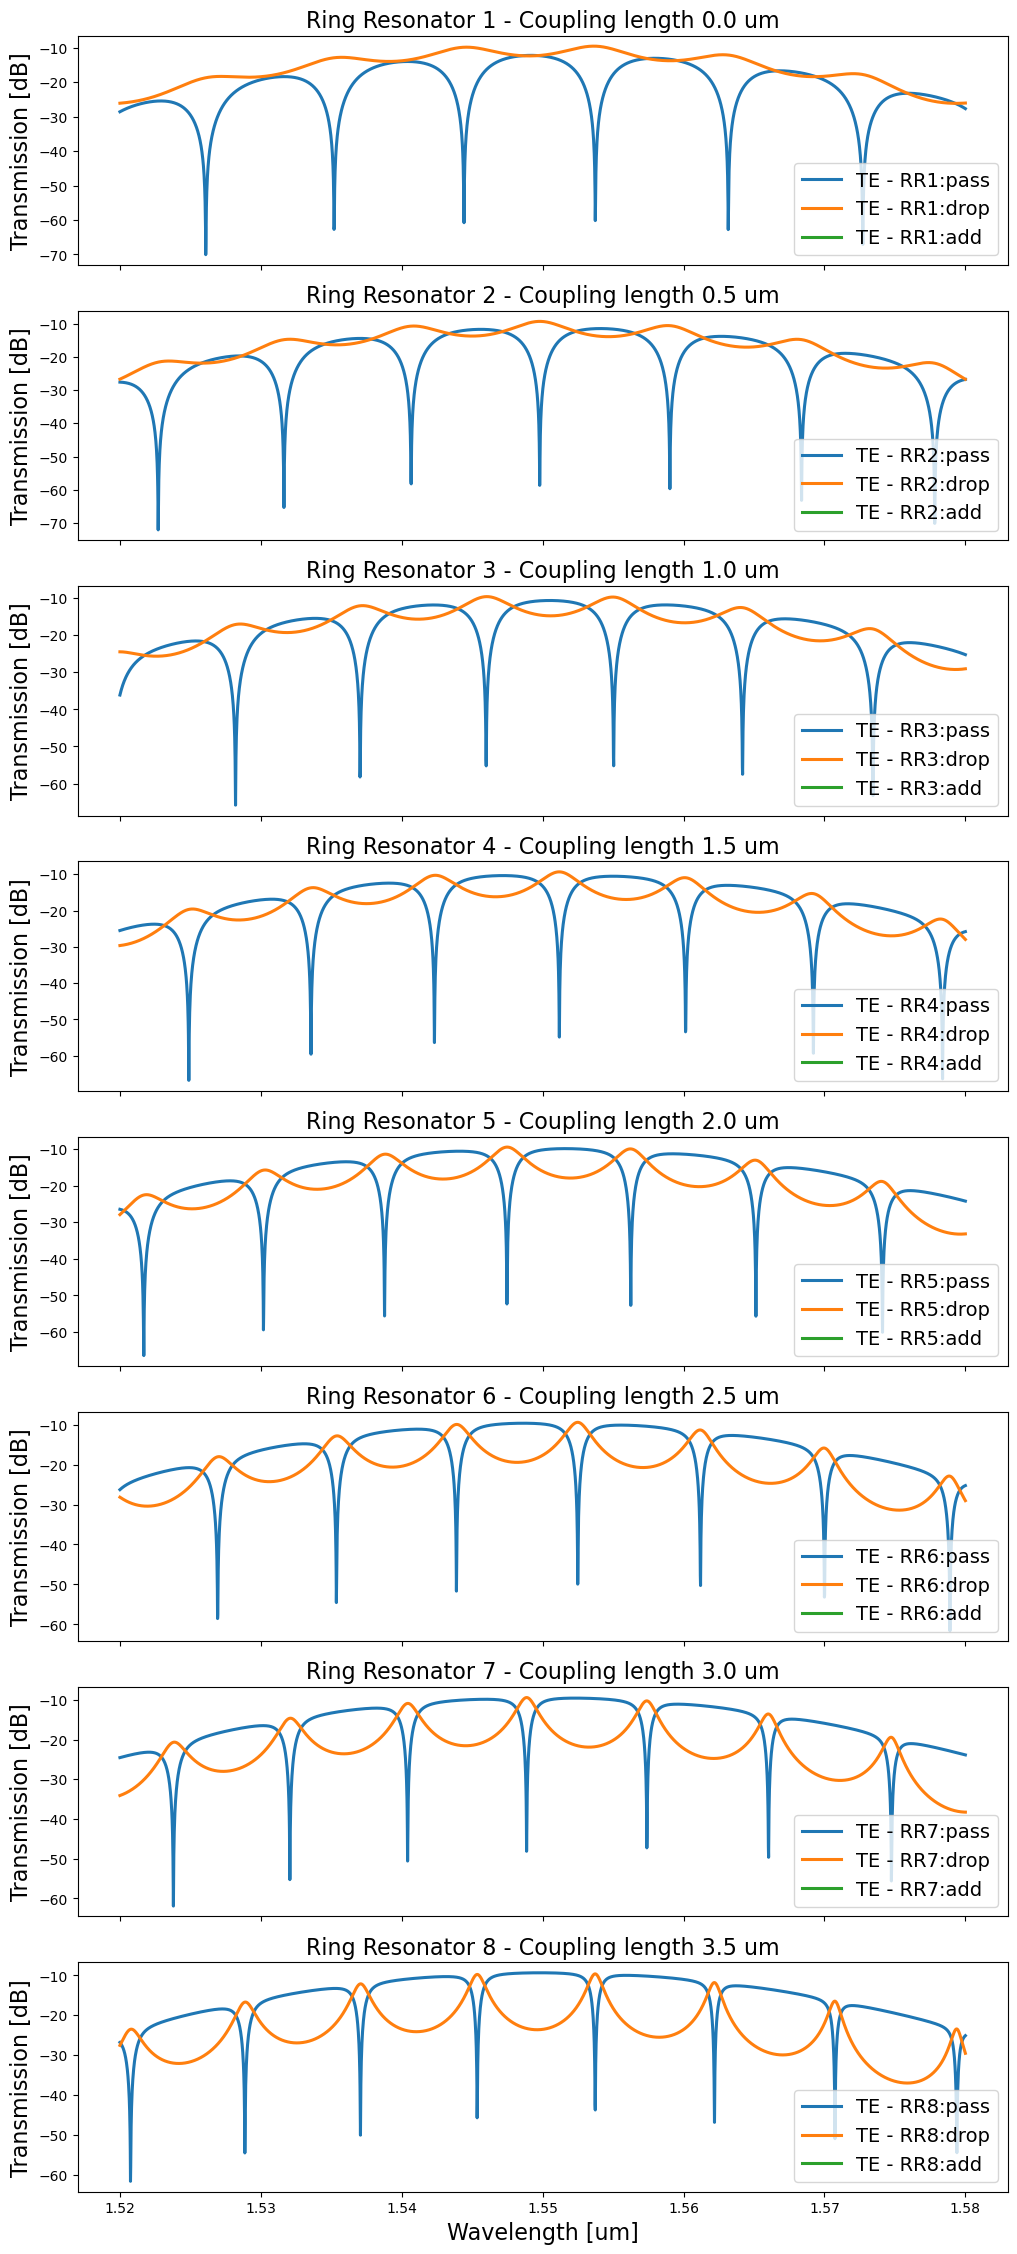

Done


In [14]:
# Plotting
fig, axs = plt.subplots(coupling_lengths.size, sharex="all", figsize=(12, 28))

# Dictionary for saving variables
m_dict = {}

for ind, coupling_length in enumerate(coupling_lengths, start=1):
    # After the colon the mode is selected (two modes) / for the particular examples S-matrix has 12x12x2 entries
    # not counting the ones due to wavelength
    circ = "RRcl{}".format(ind)
    tr_pass = i3.signal_power_dB(S_total["{}_pass:0".format(circ), "{}_in:0".format(circ)])
    tr_drop = i3.signal_power_dB(S_total["{}_drop:0".format(circ), "{}_in:0".format(circ)])
    tr_add = i3.signal_power_dB(S_total["{}_add:0".format(circ), "{}_in:0".format(circ)])

    # Indices of the axes will be zero based
    ax_idx = ind - 1
    axs[ax_idx].plot(wavelengths, tr_pass, "-", linewidth=2.2, label="TE - RR{}:pass".format(ind))
    axs[ax_idx].plot(wavelengths, tr_drop, "-", linewidth=2.2, label="TE - RR{}:drop".format(ind))
    axs[ax_idx].plot(wavelengths, tr_add, "-", linewidth=2.2, label="TE - RR{}:add".format(ind))

    axs[ax_idx].set_ylabel("Transmission [dB]", fontsize=16)
    axs[ax_idx].set_title("Ring Resonator {} - Coupling length {} um".format(ind, coupling_length), fontsize=16)
    axs[ax_idx].legend(fontsize=14, loc=4)
    m_dict[f"RR_coupling_length_{coupling_length:.2f}"] = {"pass": tr_pass, "drop": tr_drop, "add": tr_add}

savemat(f'./data/RR_circuitE.mat', m_dict)
with open(f'./data/RR_circuitE.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(m_dict, f)
axs[-1].set_xlabel("Wavelength [um]", fontsize=16)
plt.show()

print("Done")
